# Tiny Yolo - Keras - Tensorflow backend

YOLO paper: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640)

### Imports

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, MaxPooling2D, BatchNormalization, Reshape, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from preprocessing import parse_annotation, BatchGenerator
from yolo_utils import preprocess_image, decode_netout

import numpy as np
import zipfile
import os
import wget

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "" 

%matplotlib inline

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Constants

In [2]:
with open('tiny-yolo-voc-labels.txt', 'r') as f:
    LABELS = [label.rstrip('\n') for label in f.readlines()]
    
LABELS = LABELS[:5]

ANCHORS = [1.08,1.19, 3.42,4.41, 6.63,11.38, 9.42,5.11, 16.62,10.52]

IMAGE_H =  224
IMAGE_W =  224
CHANNELS = 3

GRID_H,  GRID_W  = 7 , 7
BOX = 5
CLASS = len(LABELS)

TRUE_BOX_BUFFER  = 50
BATCH_SIZE       = 64

EPSILON = 1e-8

CLASS_WEIGHTS = np.ones(CLASS, dtype='float32')

OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
WARM_UP_BATCHES  = 0

DOWNLOAD_DATA = False

### Model

In [3]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, CHANNELS))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

'''
https://keras.io/layers/convolutional/

Conv2D(filters, kernel_size, strides=(1, 1), padding='valid',      \
     data_format=None, dilation_rate=(1, 1), activation=None,      \
     use_bias=True, kernel_initializer='glorot_uniform',           \
     bias_initializer='zeros', kernel_regularizer=None,            \
     bias_regularizer=None, activity_regularizer=None,             \
     kernel_constraint=None, bias_constraint=None)
     
https://keras.io/layers/normalization/#batchnormalization

BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,          \
    center=True, scale=True, beta_initializer='zeros',             \
    gamma_initializer='ones', moving_mean_initializer='zeros',     \
    moving_variance_initializer='ones', beta_regularizer=None,     \
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

https://keras.io/layers/advanced-activations/#leakyrelu

LeakyReLU(alpha=0.3) 
It allows a small gradient when the unit is not active: f(x) = alpha * x for x < 0, f(x) = x for x >= 0

https://keras.io/layers/pooling/#maxpooling2d

MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

https://keras.io/layers/core/    -- Reshape

Reshape(target_shape)
'''
# Layer 1
X = Conv2D(filters=16, kernel_size=(3,3), padding='same', use_bias=False, name='conv_1')(input_image)
X = BatchNormalization(name='norm_1')(X)
X = LeakyReLU(alpha=0.1)(X)
X = MaxPooling2D()(X)

# Layer 2
X = Conv2D(filters=32, kernel_size=(3,3), padding='same', use_bias=False, name='conv_2')(X)
X = BatchNormalization(name='norm_2')(X)
X = LeakyReLU(alpha=0.1)(X)
X = MaxPooling2D()(X)

# Layer 3
X = Conv2D(filters=64, kernel_size=(3,3), padding='same', use_bias=False, name='conv_3')(X)
X = BatchNormalization(name='norm_3')(X)
X = LeakyReLU(alpha=0.1)(X)
X = MaxPooling2D()(X)

# Layer 4
X = Conv2D(filters=128, kernel_size=(3,3), padding='same', use_bias=False, name='conv_4')(X)
X = BatchNormalization(name='norm_4')(X)
X = LeakyReLU(alpha=0.1)(X)
X = MaxPooling2D()(X)

# Layer 5
X = Conv2D(filters=256, kernel_size=(3,3), padding='same', use_bias=False, name='conv_5')(X)
X = BatchNormalization(name='norm_5')(X)
X = LeakyReLU(alpha=0.1)(X)
X = MaxPooling2D()(X)

# Layer 6
X = Conv2D(filters=512, kernel_size=(3,3), padding='same', use_bias=False, name='conv_6')(X)
X = BatchNormalization(name='norm_6')(X)
X = LeakyReLU(alpha=0.1)(X)
X = MaxPooling2D(strides=(1,1), padding='same')(X)

# Layer 7
X = Conv2D(filters=512, kernel_size=(3,3), padding='same', use_bias=False, name='conv_7')(X)
X = BatchNormalization(name='norm_7')(X)
X = LeakyReLU(alpha=0.1)(X)

# Layer 8
# BOX=5, CLASS=20, GRID_H=13, GRID_W=13
X = Conv2D(BOX * (4 + 1 + CLASS), kernel_size=(1, 1), kernel_initializer='he_normal')(X)
Y = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(X)       # X = [None, 13, 13, 125], Y = [None, 13, 13, 5, 25]

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
Y = Lambda(lambda args: args[0])([Y, true_boxes])

# Create model
model = Model([input_image, true_boxes], Y)

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 224, 224, 16) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Update network with pre-trained weights (if any)

In [5]:
if(os.path.isdir("weights")):
    if(os.path.exists("weights/yolov2-tiny-voc.weights")):
        print("file already exists")
    else:
        os.chdir("weights/")
        url = 'https://pjreddie.com/media/files/yolov2-tiny-voc.weights'
        wget.download(url)
        os.chdir("../")
else:
    os.makedirs("weights")
    os.chdir("weights/")
    url = 'https://pjreddie.com/media/files/yolov2-tiny-voc.weights'
    wget.download(url)
    os.chdir("../")

file already exists


In [6]:
class weight_reader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        read = self.all_weights[self.offset : self.offset + size]
        self.offset = self.offset + size
        return read

In [7]:
if(os.path.exists('weights/yolov2-tiny-voc.weights')):
    wr = weight_reader('weights/yolov2-tiny-voc.weights')
    conv_ = 7
    
    for i in range(1, conv_ + 1):
        conv_layer = model.get_layer('conv_' + str(i))
    
        if i < conv_:
            norm_layer = model.get_layer('norm_' + str(i))
            size = np.prod(norm_layer.get_weights()[0].shape)
        
            beta  = wr.read_bytes(size)
            gamma = wr.read_bytes(size)
            mean  = wr.read_bytes(size)
            var   = wr.read_bytes(size)
        
            weights = norm_layer.set_weights([gamma, beta, mean, var])
        
        if len(conv_layer.get_weights()) > 1:
            bias   = wr.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = wr.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel, bias])
        else:
            kernel = wr.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel])
        
    print('Model loaded with pre-trained weights.')
else:
    print('Weights file doesn\'t exists.')

Model loaded with pre-trained weights.


In [17]:
if(os.path.exists('CheckPoint/weights.02-0.41-0.96.hdf5')):
    from keras.models import load_model
    model.load_weights('CheckPoint/weights.02-0.41-0.96.hdf5')
    print('Model loaded with pre-trained weights.')

Model loaded with pre-trained weights.


# Download Training and Testing data

In [9]:
if (DOWNLOAD_DATA == True):
    # Save current directory path
    curr_dir = os.getcwd()

    # Training Data
    if(os.path.isdir("data") and os.path.exists("data/train2014.zip")):
        if(os.path.isdir("data/Ext/images/train2014") and len(os.listdir('data/Ext/images/train2014')) != 0):
            print('Training files available on disk.')
        else:
            with zipfile.ZipFile("data/train2014.zip", 'r') as zip_ref:
                zip_ref.extractall("data/Ext/images/")
    else:
        if(os.path.isdir("data")):
            os.chdir("data/")
        else:
            os.makedirs("data/Ext/images")
            os.chdir("data/")
        url = 'http://images.cocodataset.org/zips/train2014.zip'
        filename = wget.download(url)
        with zipfile.ZipFile("train2014.zip", 'r') as zip_ref:
            zip_ref.extractall("./Ext/images")

    os.chdir(curr_dir)

    # Training Data Annotation
    if(os.path.isdir("data") and os.path.exists("data/annotations_trainval2014.zip")):
        if(os.path.isdir("data/Ext/annotations") and len(os.listdir('data/Ext/annotations')) != 0):
            print('Training annotation files available on disk.')
        else:
            with zipfile.ZipFile("data/annotations_trainval2014.zip", 'r') as zip_ref:
                zip_ref.extractall("data/Ext/")
    else:
        if(os.path.isdir("data")):
            os.chdir("data/")
        else:
            os.makedirs("data")
            os.chdir("data/")
        url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
        filename = wget.download(url)
        with zipfile.ZipFile("annotations_trainval2014.zip", 'r') as zip_ref:
            zip_ref.extractall("./Ext/")

    os.chdir(curr_dir)

    # Validation/Testing Data Annotation
    if(os.path.isdir("data") and os.path.exists("data/val2014.zip")):
        if(os.path.isdir("data/Ext/images/val2014") and len(os.listdir('data/Ext/images/val2014')) != 0):
            print('Validation / Testing files available on disk.')
        else:
            with zipfile.ZipFile("data/val2014.zip", 'r') as zip_ref:
                zip_ref.extractall("data/Ext/images/")
    else:
        if(os.path.isdir("data")):
            os.chdir("data/")
        else:
            os.makedirs("data")
            os.chdir("data/")
        url = 'http://images.cocodataset.org/zips/val2014.zip'
        filename = wget.download(url)
        with zipfile.ZipFile("val2014.zip", 'r') as zip_ref:
            zip_ref.extractall("./Ext/images/")

    os.chdir(curr_dir)

# Convert data from COCO format to VOC

In [10]:
if (DOWNLOAD_DATA == True):
    os.makedirs("data/Ext/images/train2014ann")
    !python coco2pascal.py create_annotations data/Ext train data/Ext/images/train2014ann

In [11]:
if (DOWNLOAD_DATA == True):
    os.makedirs("data/Ext/images/val2014ann")
    !python coco2pascal.py create_annotations data/Ext val data/Ext/images/val2014ann

In [17]:
training_data   = "D:/yolo-data/data/Ext/images/train2014/"
training_data_ann = "D:/yolo-data/data/Ext/images/train2014ann/"
validation_data = "D:/yolo-data/data/Ext/images/val2014/"
validation_data_ann = "D:/yolo-data/data/Ext/images/val2014ann/"

# Parse annotations to generator training and validation generator

In [4]:
gen_config = {
    'IMAGE_H'          : IMAGE_H,
    'IMAGE_W'          : IMAGE_W,
    'GRID_H'           : GRID_H,
    'GRID_W'           : GRID_W,
    'BOX'              : BOX,
    'LABELS'           : LABELS,
    'CLASS'            : len(LABELS),
    'ANCHORS'          : ANCHORS,
    'BATCH_SIZE'       : (BATCH_SIZE * 200),
    'TRUE_BOX_BUFFER'  : TRUE_BOX_BUFFER,
}

In [18]:
def normalize(image):
    return image / 255

In [6]:
# Costly call (~ 15min)
train_imgs, seen_train_labels = parse_annotation(training_data_ann, \
                                                 training_data,     \
                                                 labels=LABELS)

In [7]:
train_batch = BatchGenerator(train_imgs, gen_config, norm=normalize)

In [8]:
train = 0
for [X1, X2], Y in train_batch:
    np.savez('D:/yolo-data/data/Ext/images/train2014npz/np-{0:0=5d}.npz'.format(train), X1=X1, X2=X2, Y=Y)
    train += 1

KeyboardInterrupt: 

In [19]:
gen_config = {
    'IMAGE_H'          : IMAGE_H,
    'IMAGE_W'          : IMAGE_W,
    'GRID_H'           : GRID_H,
    'GRID_W'           : GRID_W,
    'BOX'              : BOX,
    'LABELS'           : LABELS,
    'CLASS'            : len(LABELS),
    'ANCHORS'          : ANCHORS,
    'BATCH_SIZE'       : (BATCH_SIZE * 20),
    'TRUE_BOX_BUFFER'  : TRUE_BOX_BUFFER,
}

In [20]:
# Costly call (~ 10min)
valid_imgs, seen_valid_labels = parse_annotation(validation_data_ann, \
                                                 validation_data,     \
                                                 labels=LABELS)

In [21]:
valid_batch = BatchGenerator(valid_imgs, gen_config, norm=normalize, jitter=False)

In [27]:
valid = 0
for [X1, X2], Y in valid_batch:
    np.savez('D:/yolo-data/data/Ext/images/valid2014npz/np-{0:0=5d}.npz'.format(valid), X1=X1, X2=X2, Y=Y)
    valid += 1
    if(train == valid):
        break

# Loss Function

## 1 - Classification Loss

if an object is detected, the classification loss at each cell is the squared error of the class conditional probabilities for each loss:

<img src="images/ClassificationLoss.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Classification Loss**<br> </center></caption>

In [9]:
def classification_loss(y_true, y_pred):

    mask_shape = tf.shape(y_true)[:4]
    
    class_mask = tf.zeros(mask_shape)
    
    # true classification box
    true_box_class = tf.argmax(y_true[...,5:], -1)
    
    # classification mask
    class_mask = y_true[...,4] * tf.gather(CLASS_WEIGHTS, true_box_class)

    # number of classification boxes
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    # predicted box
    pred_box_class = y_pred[...,5:]

    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + EPSILON)
    
    loss_class = tf.Print(loss_class, [loss_class], message='Loss Class \t', summarize=1000)
    
    return loss_class

## 2 - Localization Loss

The localization loss measures the errors in the predicted boundary box locations and sizes. We only count the box responsible for detecting the object.

<img src="images/LocalizationLoss.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 2** </u>: **Localization Loss**<br> </center></caption>

We do not want to weight absolute errors in large boxes and small boxes equally. i.e. a 2-pixel error in a large box is the same for a small box. To partially address this, YOLO predicts the square root of the bounding box width and height instead of the width and height. In addition, to put more emphasis on the boundary box accuracy, we multiply the loss by λcoord (default: 5).

In [10]:
def localization_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically   
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1)
    
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])

    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    
    Localization_Loss = loss_xy + loss_wh
    
    # Localization_Loss = tf.Print(Localization_Loss, [loss_xy], message='Loss XY \t', summarize=1000)
    # Localization_Loss = tf.Print(Localization_Loss, [loss_wh], message='Loss WH \t', summarize=1000)
    
    return Localization_Loss

## 3 - Confidence Loss

If an object is detected in the box, the confidence loss (measuring the objectness of the box) is:

<img src="images/ConfidenceLoss1.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 3** </u>: **Confidence Loss**<br> </center></caption>

If an object is not detected in the box, the confidence loss is:

<img src="images/ConfidenceLoss2.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 4** </u>: **Confidence Loss**<br> </center></caption>

Most boxes do not contain any objects. This causes a class imbalance problem, i.e. we train the model to detect background more frequently than detecting objects. To remedy this, we weight this loss down by a factor λnoobj (default: 0.5).

In [11]:
def confidence_loss(y_true, y_pred):
    
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    conf_mask  = tf.zeros(mask_shape)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4])
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE

    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))

    loss_conf  = tf.reduce_sum(tf.square(true_box_conf - pred_box_conf) * conf_mask)  / (nb_conf_box  + EPSILON) / 2.
    
    # loss_conf = tf.Print(loss_conf, [loss_conf], message='Loss Conf \t', summarize=1000)
    
    return loss_conf

## Total Loss

The final loss adds localization, confidence and classification losses together.

<img src="images/TotalLoss.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 5** </u>: **Total Loss**<br> </center></caption>

In [12]:
def total_loss(y_true, y_pred):
    loss = classification_loss(y_true, y_pred) + localization_loss(y_true, y_pred) + confidence_loss(y_true, y_pred)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    return loss

# Optimizer (Adam)

In [13]:
'''
https://keras.io/optimizers/

Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
'''

optimizer = Adam(lr=0.5e-4, epsilon=EPSILON)

# Configure the model for training

In [14]:
'''
https://keras.io/models/sequential/

compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, \
                                                        weighted_metrics=None, target_tensors=None)
'''
model.compile(loss=total_loss, optimizer=optimizer)

# Callbacks

In [15]:
'''
https://keras.io/callbacks/

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', \
                                                  baseline=None, restore_best_weights=False)

ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False,  \
                                              save_weights_only=False, mode='auto', period=1)
'''
EarlyStop = EarlyStopping(min_delta=0.001, patience=5, mode='min', verbose=1)

if(os.path.isdir("CheckPoint")):
    print('Check point directory exists.')
else:
    os.makedirs("CheckPoint")

MakeCheckPoint = ModelCheckpoint("CheckPoint/weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5", \
                                 verbose=1, save_best_only=True, mode='min')

Check point directory exists.


# Start Training

In [16]:
'''
https://keras.io/models/model/#fit

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, \
            validation_split=0.0, validation_data=None, shuffle=True, \
            class_weight=None, sample_weight=None, initial_epoch=0, \
            steps_per_epoch=None, validation_steps=None)
'''
for j in range(5):
    for i in range(4):
        TX1 = []
        TX2 = []
        TY  = []
        file = 'D:/yolo-data/data/Ext/images/train2014npz/np-{0:0=5d}.npz'.format(i)
        data = np.load(file)
        TX1.append(data['X1'])
        TX2.append(data['X2'])
        TY.append(data['Y'])

        VX1 = []
        VX2 = []
        VY  = []
        file = 'D:/yolo-data/data/Ext/images/valid2014npz/np-{0:0=5d}.npz'.format(i)
        data = np.load(file)
        VX1.append(data['X1'])
        VX2.append(data['X2'])
        VY.append(data['Y'])

        model.fit([TX1[0], TX2[0]], TY[0], batch_size=64, epochs=25, \
                    verbose=1, validation_data=([VX1[0], VX2[0]], VY[0]), \
                    callbacks = [EarlyStop, MakeCheckPoint])

Train on 12800 samples, validate on 1280 samples
Epoch 1/25
12800/12800 [==============================] - 74s 6ms/step - loss: 0.5606 - val_loss: 1.0972

Epoch 00001: val_loss improved from inf to 1.09718, saving model to CheckPoint/weights.01-0.56-1.10.hdf5
Epoch 2/25
12800/12800 [==============================] - 74s 6ms/step - loss: 0.4980 - val_loss: 1.0527

Epoch 00002: val_loss improved from 1.09718 to 1.05271, saving model to CheckPoint/weights.02-0.50-1.05.hdf5
Epoch 3/25
12800/12800 [==============================] - 70s 5ms/step - loss: 0.4243 - val_loss: 1.0878

Epoch 00003: val_loss did not improve from 1.05271
Epoch 4/25
12800/12800 [==============================] - 68s 5ms/step - loss: 0.3935 - val_loss: 1.1323

Epoch 00004: val_loss did not improve from 1.05271
Epoch 5/25
12800/12800 [==============================] - 67s 5ms/step - loss: 0.3298 - val_loss: 1.0982

Epoch 00005: val_loss did not improve from 1.05271
Epoch 6/25
12800/12800 [==============================

KeyboardInterrupt: 

### Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 5** </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="images/iou.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 6** </u>: Definition of "Intersection over Union". <br> </center></caption> 

## Test Tiny YOLO

In [17]:
def predict(xmodel, image_file):

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (IMAGE_H, IMAGE_W))


    _array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

    netout = xmodel.predict([image_data, _array])

    return netout

In [18]:
def decode_network_output(netout):
    return decode_netout(netout[0], 
                        anchors=ANCHORS, 
                        nb_class=CLASS)

Run the following cell on the "test.jpg" image to verify that your function is correct.

In [29]:
netout = predict(model, "COCO_train2014_000000012138.jpg")

In [30]:
boxes = decode_network_output(netout)

In [31]:
for box in boxes:
    print(LABELS[box.get_label()])

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

In [18]:
LABELS

['airplane', 'bicycle', 'bird', 'boat', 'bottle']

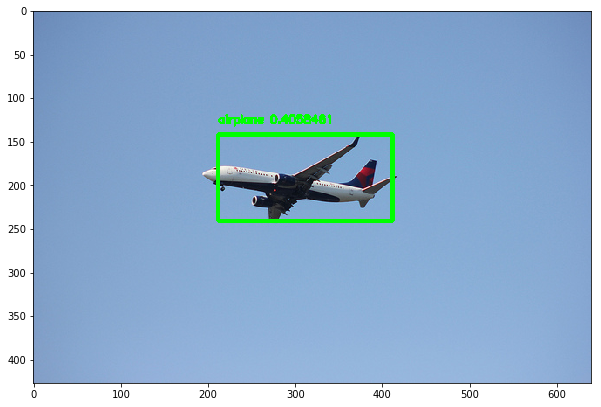

In [25]:
import cv2
import matplotlib.pyplot as plt
from yolo_utils import draw_boxes

OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45

image = cv2.imread('images/COCO_train2014_000000012138.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()